In [1]:
# !mkdir spark_data
# for schema in ['football_games','labels','features']:
#     for tbl in spark.sql(f'SHOW TABLES in {schema}').toPandas()\
#                 [['database','tableName']].apply(lambda x: '.'.join(x), axis=1)\
#                 .values:
#         print(tbl)
#         spark.sql(f'SELECT * FROM {tbl}').toPandas().to_csv(f'spark_data/{tbl}.csv', index=False)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%run ../config/initialize.ipynb

import pickle as pickle
import json

In [4]:
sys.path.append('../../config')
from mpl_style import *

rcParams['figure.dpi'] = 96
rcParams['figure.figsize'] = (12,8)

In [5]:
import matplotlib as mpl
params_backup = rcParams.copy()

In [6]:
import sys 
path='/Users/joshplotkin/Dropbox/data_science/modeling-football-outcomes/04_model_pipeline_dev/'
os.chdir(path)
from CVData import CVData
from TrainAndScoreModel import TrainAndScoreModel
from EvaluateModel import EvaluationData, EvaluateAndPlot

In [7]:
model_dict = json.load(open('model.json','r'))

### Check model.json

In [8]:
assert type(model_dict['index']) is list
assert type(model_dict['label_col']) in [str, bytes]
assert type(model_dict['features_tbl']) in [str, bytes]
assert type(model_dict['features_tbl']) in [str, bytes]
assert type(model_dict['features_list']) is list
assert type(model_dict['pos_labels']) is list

## assert format is schema.table and that
## table exists in hive
for tbl_str in ['features_tbl','features_tbl']:
    schema_and_tbl = model_dict[tbl_str].split('.')
    assert len(schema_and_tbl) == 2
    schema, tbl = schema_and_tbl
    assert spark.sql(
            'show tables in {}'.format(schema)
        ).filter(
            col('tableName') == tbl
        ).count() == 1
    
## assert that labels and features share identical index
a = spark.table(model_dict['features_tbl']).count()
b = spark.table(model_dict['labels_tbl']).count()
c = spark.table(model_dict['features_tbl']).join(
    spark.table(model_dict['labels_tbl']),
    on=model_dict['index']
).count()
assert a == b
assert a == c

feat_cols_set = set(spark.table(model_dict['features_tbl']).columns)
label_cols_set = set(spark.table(model_dict['labels_tbl']).columns)
idx_set = set(model_dict['index'])
feat_set = set(model_dict['features_list'])
label_set = set([model_dict['label_col']])

## assert the chosen columns exist in the
## chosen tables
assert not idx_set - feat_cols_set
assert not idx_set - label_cols_set
assert not feat_set - feat_cols_set
assert not label_set - label_cols_set

## check that positive and negative label values 
## are valid
for label_val in ['pos_labels','neg_labels']:
    assert spark.table(
            model_dict['labels_tbl']
        ).filter(
            col(model_dict['label_col']).isin(model_dict[label_val])
        ).count() > 0

### Cross-validation sets

## if this entry is None, make sure the 
## reference directory exists.
if model_dict['model_cv_to_use']:
    assert type(model_dict['model_cv_to_use']) in [str, unicode]
    assert os.path.exists('../{}'.format(model_dict['model_cv_to_use']))
else:
    ## assert the data structures/types are correct
    assert type(model_dict['kfold_seed']) is int
    assert type(model_dict['dataset_seed']) is int
    assert type(model_dict['kfolds']) is int
    assert type(model_dict['strata_cols']) is list
    assert type(model_dict['global_dataset_proportions']) is dict
    assert type(model_dict['dimensional_dataset_proportions']) is dict
    assert type(model_dict['holdout_set']) is dict

    ## assert strata cols are present in the labels table
    assert not set(model_dict['strata_cols']) - label_cols_set

    dataset_types = set(['in_training','holdout','throw_away','scoring_only'])
    global_datasets = model_dict['global_dataset_proportions']
    dim_datasets = model_dict['dimensional_dataset_proportions']

    ## assert global_dataset_proportions has all possible dataset types
    assert set(global_datasets.keys()) == dataset_types
    ## values are proportions that must sum to 1
    assert sum(global_datasets.values()) == 1
    ## assert that the keys are valid dataset types
    assert not set(dim_datasets.keys()) - dataset_types
    ## assert the following (in order of assertion block):
    ## (1) each value is a list
    ## (2) each element of the list is a dict
    ## (3) each dict has the 5 required keys
    ## (4) the "dim" field is in the strata columns 
    ## (5) "prop_to_move" field is [0, 1]
    ## (6) "from_groups" are in the possible dataset types
    for k, dim_list in dim_datasets.items():
        assert (type(dim_list)) is list
        for entry in dim_list:
            assert type(entry) is dict
            assert set(entry.keys()) \
                    == set(['vals','dim','prop_to_move','from_groups'])
            assert entry['dim'] in model_dict['strata_cols']
            assert 0 <= entry['prop_to_move'] <= 1
            assert not set(entry['from_groups']) - dataset_types

    ## assert holdout set has 2 keys (store_to_disk, score_using_full_model)
    ## and the corresponding values are boolean
    assert set(model_dict['holdout_set'].keys()) \
            == set(['store_to_disk','score_using_full_model'])
    assert len(list(filter(
        lambda x: type(x) is not bool, 
        model_dict['holdout_set'].values()
    ))) == 0
    ## if holdout data isn't stored, it can't be scored
    assert not (model_dict['holdout_set']['store_to_disk'] is False) \
                & (model_dict['holdout_set']['score_using_full_model'] is True)

### Model Choice
## test that model object can be created
## from model inputs
try:
    import importlib

    model_class_str = model_dict['model']
    model_obj_path = '.'.join(model_class_str.split('.')[:-1])
    model_name = model_class_str.split('.')[-1]
    model_package = importlib.import_module(model_obj_path)
    model_class = getattr(model_package, model_name)
    _ = model_class(**model_dict['model_params'])
except Exception as e:
    e

### Plot Labels
# assert type(plots_dict['label_map']) is dict
# assert type(plots_dict['success_name']) in [str, unicode]
# assert set(plots_dict['label_map'].keys()) == set(['0','1'])

# ### Bins to plot
# ## currently only supports "Bin" and "Percentile"
# assert not set(plots_dict['bin_types']) - set(['Bin','Percentile'])
# ## all plot bins values should be ints
# assert plots_dict['plot_bins'] == map(int, plots_dict['plot_bins'])
# ## ensure all bins values are in [2, 1000]
# assert filter(
#         lambda x: 2 <= x <= 1000, plots_dict['plot_bins']
#     )   == plots_dict['plot_bins']

# ### Threshold plots
# assert type(plots_dict['threshold_metrics']) is list
# ## currently only supports Accuracy and F1
# assert not set(plots_dict['threshold_metrics']) - set(['Accuracy','F1'])
for val in model_dict['dimensional_dataset_proportions'].values():
    for element in val:
        assert element['dim'] in model_dict['strata_cols']

print('JSON configuration files passed checks.')

JSON configuration files passed checks.


## Start executing

### Generate CV Sets

In [9]:
outdir = '/Users/joshplotkin/Dropbox/data_science/modeling-football-outcomes/models/0528_dev'

model_dict = json.load(open(f'{path}/model.json'))
cv = CVData(model_dict, spark)
cv.generate_cv_data()
model_data = cv.get_csv_data(write_dir=outdir)

In [10]:
for k,v in model_data.items():
    print(k, v.shape[0])

training 1531
scoring_only 0
holdout 331


### Train/Score

In [11]:
model = TrainAndScoreModel(model_dict)
model.init_model()
model.cv_score(model_data['training'], 
               model_data['scoring_only'])

In [12]:
model.cv_scores.head()

,rankings___v__dave_or_wtddvoa,weather___humidity_pct,travel___h_travel_from_last_game_decay,home_field___v_visitor__ovr_wr_ytd,rankings___v__offensedvoa,rankings___h__defensedvoa,rankings___v__estim_winrate,team_history___h_ovr_wr_ytd,home_field___v_visitor__ovr_wr_last_8_games,rankings___h__offensedvoa,...,rankings___h__estim_winrate,rankings___v__defensedvoa,rankings___h__s_t_dvoa,weather___wind_chill,travel___v_travel_from_last_game_decay,label,fold,season,week_id,score
game_id,,,,,,,,,,,,,,,,,,,,,
200811090nyj,-36.7,46.0,5.102279,0.250000,-15.7,0.9,0.225000,0.625000,0.250000,-1.5,...,0.550000,24.3,0.7,53.0,16.258409,1,0,2008,10,0.784044
201012260kan,8.2,77.0,4.315388,0.428571,0.9,5.1,0.578571,0.642857,0.500000,11.0,...,0.535714,-6.6,-2.0,10.0,8.233557,1,0,2010,16,0.129211
201310200car,-15.6,42.0,15.777061,0.500000,-10.5,-13.8,0.333333,0.400000,0.333333,3.6,...,0.620000,8.4,-1.0,68.0,15.576929,1,0,2013,7,0.776584
201510250kan,17.4,57.0,6.059326,0.666667,19.8,7.3,0.666667,0.166667,0.666667,-0.6,...,0.366667,-0.4,3.6,58.0,14.535424,1,0,2015,7,0.748089
200712090oti,18.5,85.0,0.000000,0.583333,5.4,-11.5,0.583333,0.583333,0.333333,-10.4,...,0.491667,-4.8,-3.9,69.0,8.233557,0,0,2007,14,0.507881


## Plot
* Note: ridge plot crashes jupyter

In [26]:
plots_dict = json.load(open('plots.json','r'))

In [27]:
scores_df = model.cv_scores.copy()

In [28]:
# import logging
# logger = logging.getLogger()
# logger.setLevel(logging.WARN)

### Method 1: Easy Plot All

In [30]:
plots_dict['save_plots'] = True
plots_dict['save_stats'] = True
plot = EvaluateAndPlot(plots_dict, scores_df)
plot.plot_all()

<Figure size 720x480 with 0 Axes>

<Figure size 1152x768 with 0 Axes>

<Figure size 1152x768 with 0 Axes>

<Figure size 1152x768 with 0 Axes>

<Figure size 1152x768 with 0 Axes>

<Figure size 1152x768 with 0 Axes>

<Figure size 1152x768 with 0 Axes>

### Method 2: Get Data and (optionally) Plots Second

#### Manual Data

In [31]:
evalu = EvaluationData(plots_dict, scores_df)

acc_dfs = {}
for metric in plots_dict['threshold_metrics']:
    acc_dfs[metric] = evalu.get_threshold_data(metric)

ridge_df = evalu.get_ridge_data()

mean_auc = evalu.get_mean_auc()

bins_dfs = {}
for bin_type in plots_dict['bin_types']:
    bins_dfs[bin_type] = {}
    for nbins in plots_dict['plot_bins']:
        bins_dfs[bin_type][nbins] = evalu.get_bins_data(bin_type, nbins)
    
acc_topn = {}
for col_range in plots_dict['accuracy_at_topn'].items():
    acc_topn[col_range[0]] = evalu.get_accuracy_at_topn(*col_range)

#### Manual plot

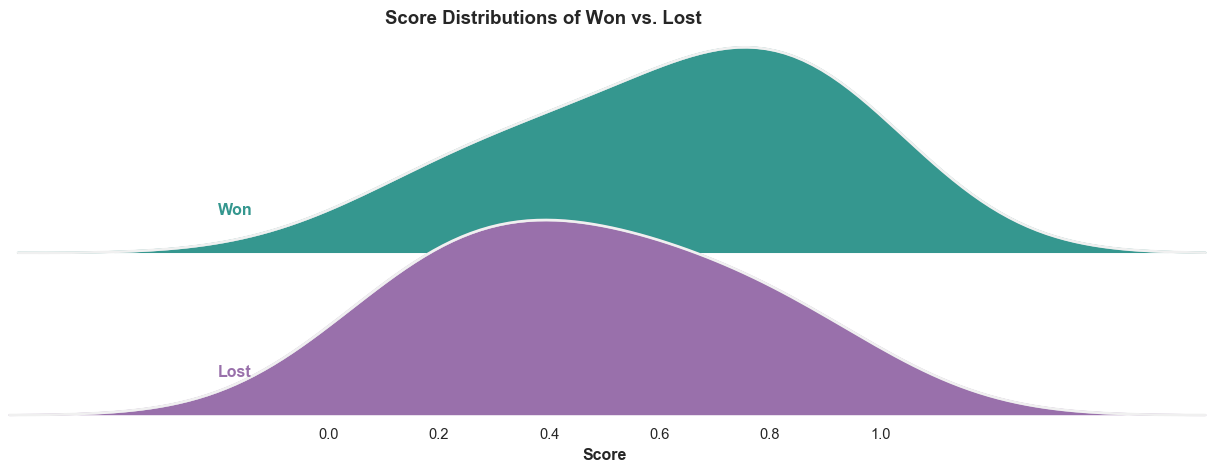

<Figure size 1152x768 with 0 Axes>

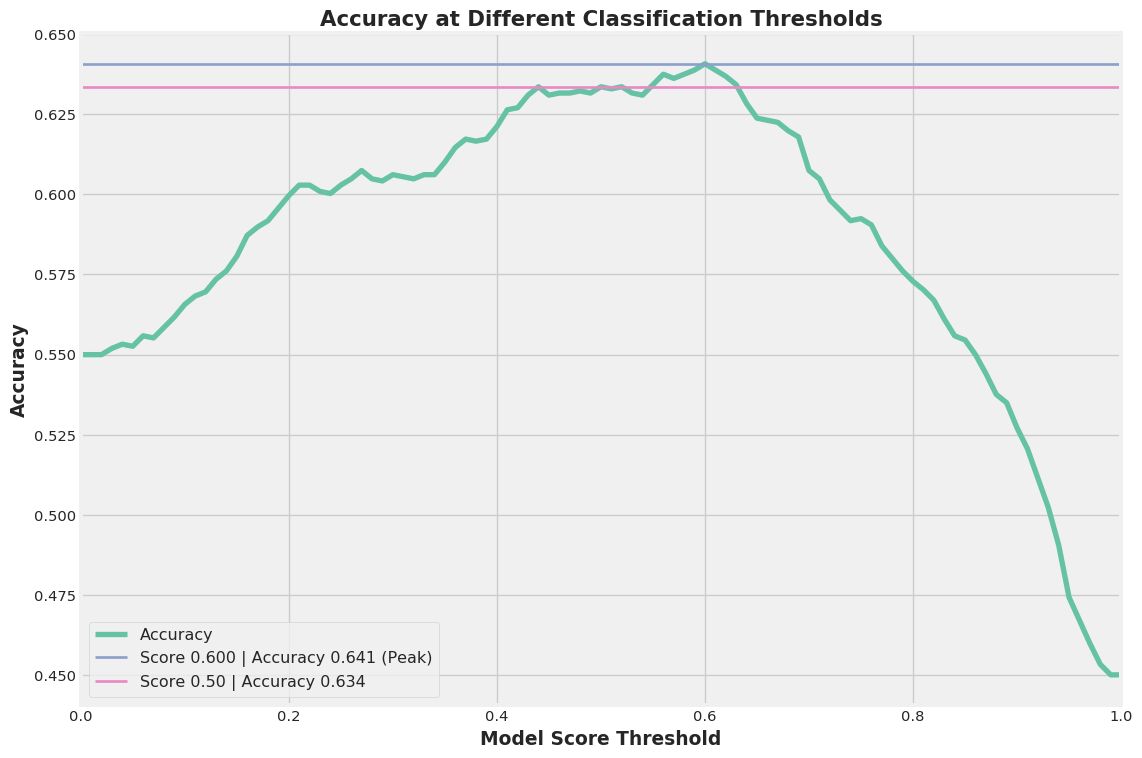

<Figure size 1152x768 with 0 Axes>

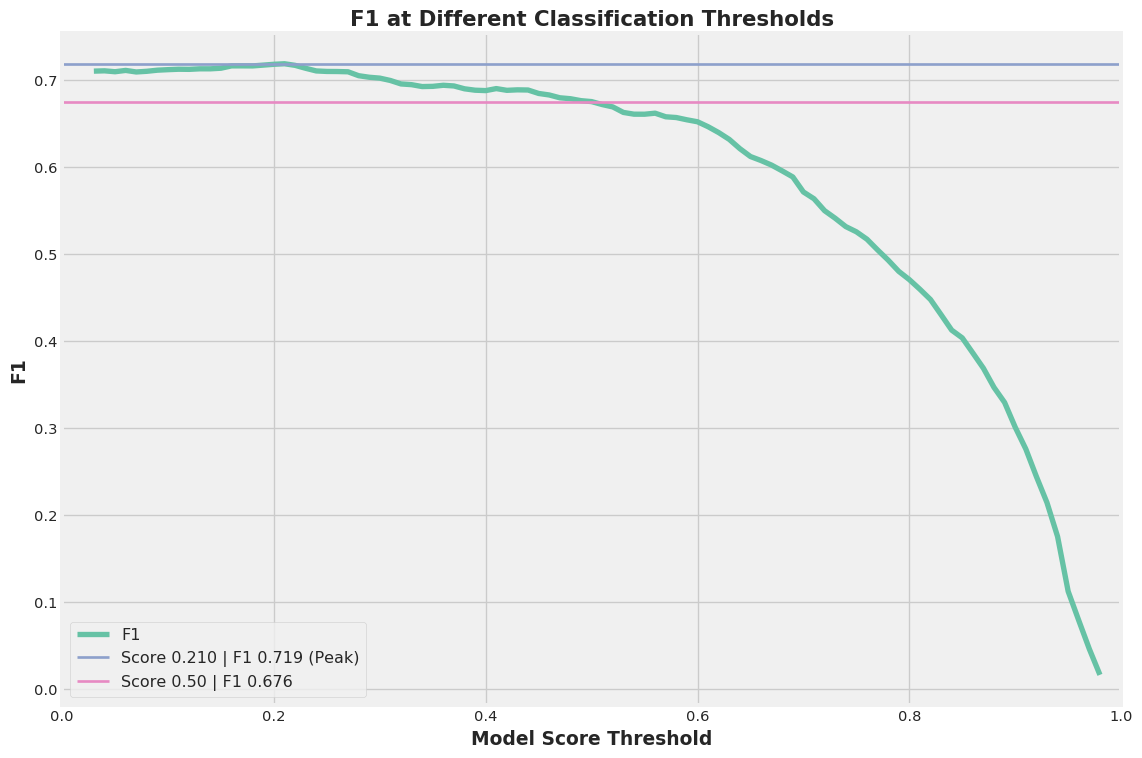

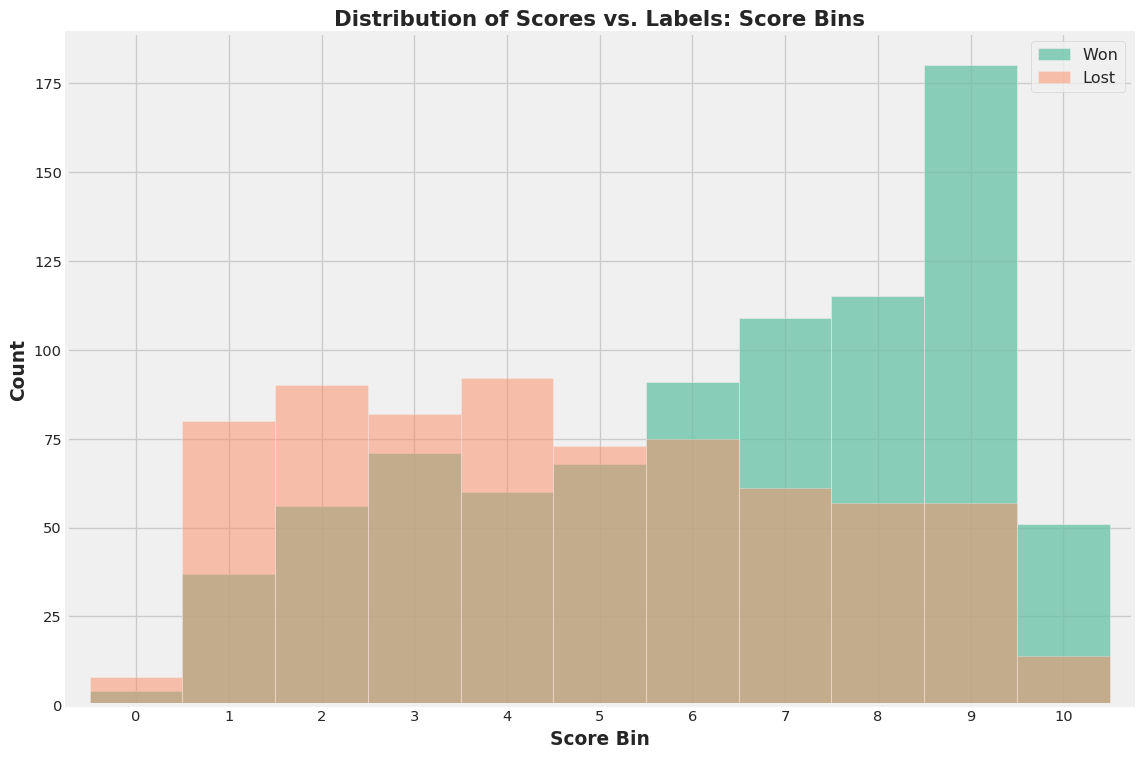

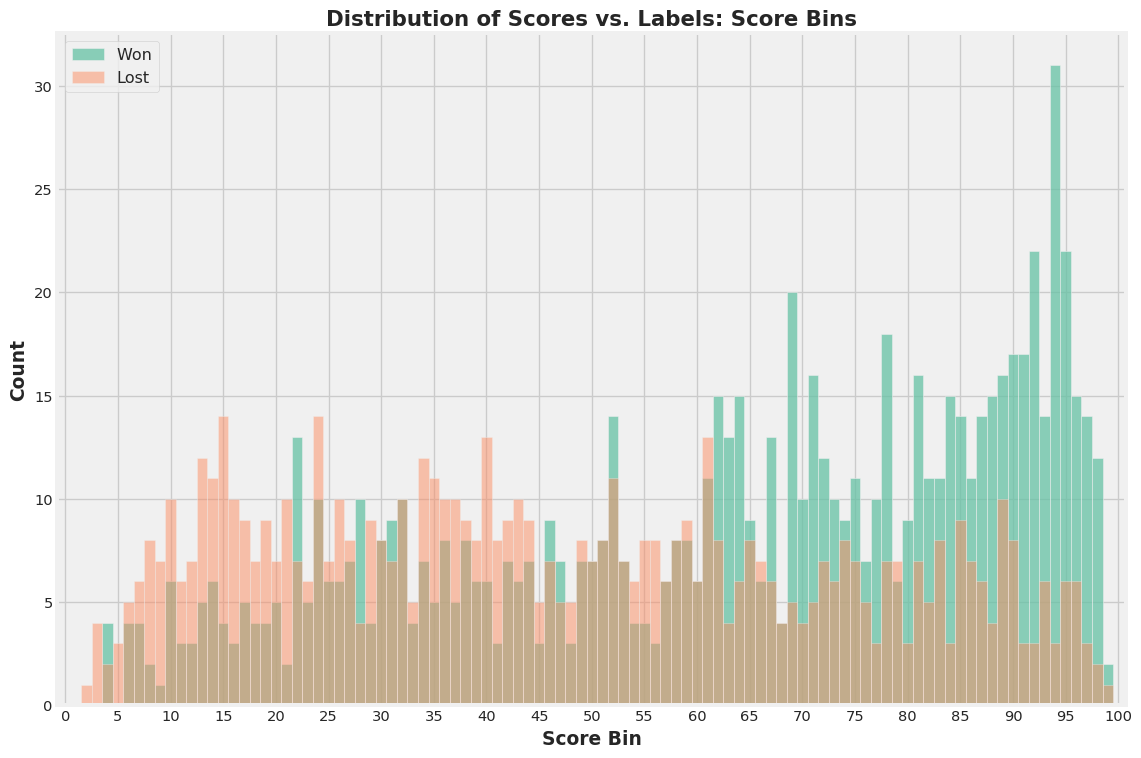

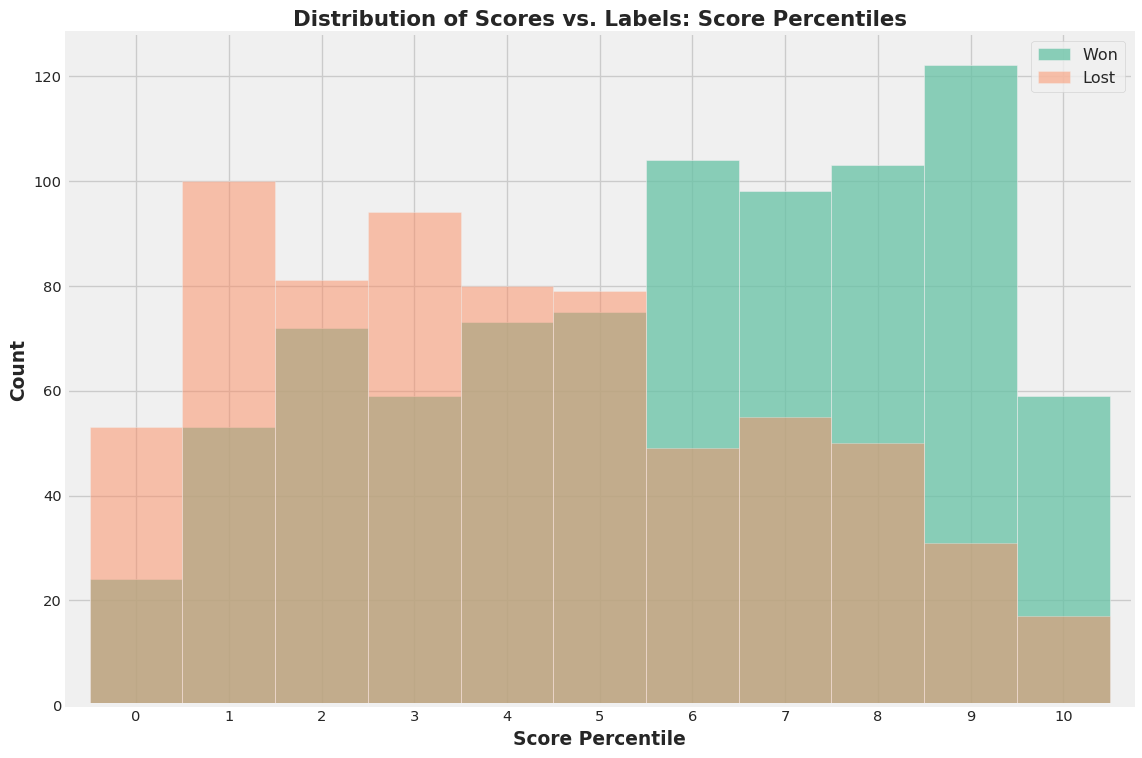

<Figure size 1152x768 with 0 Axes>

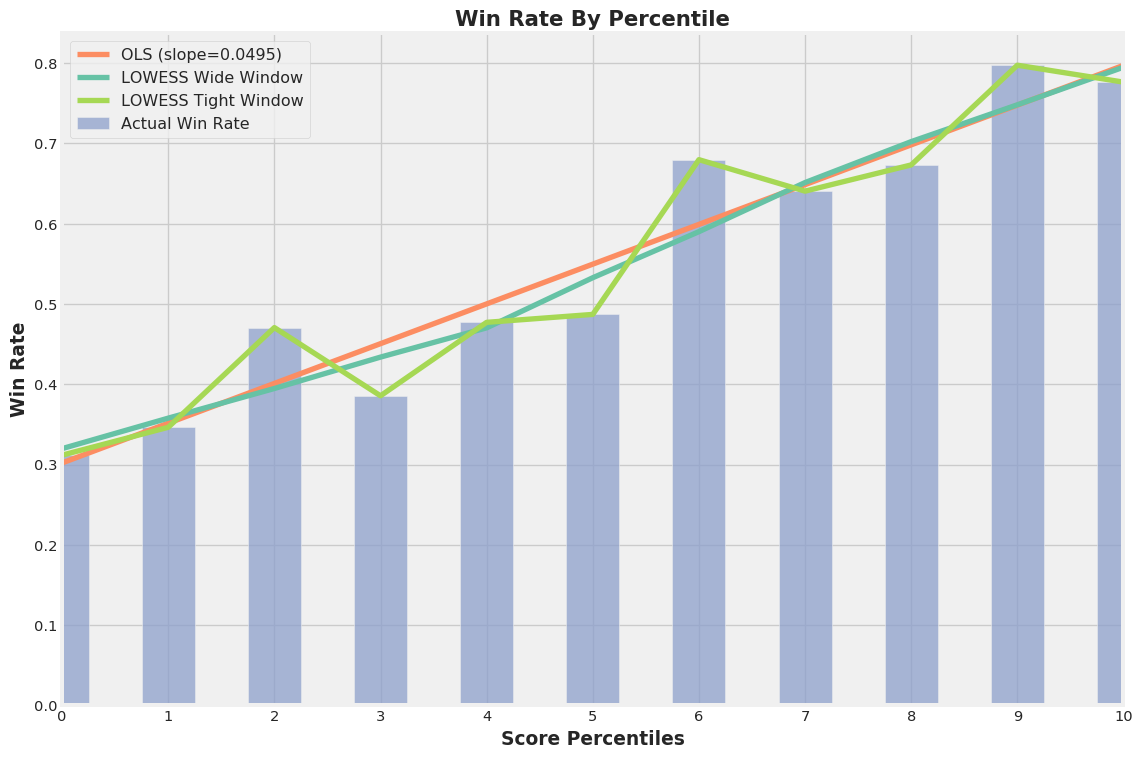

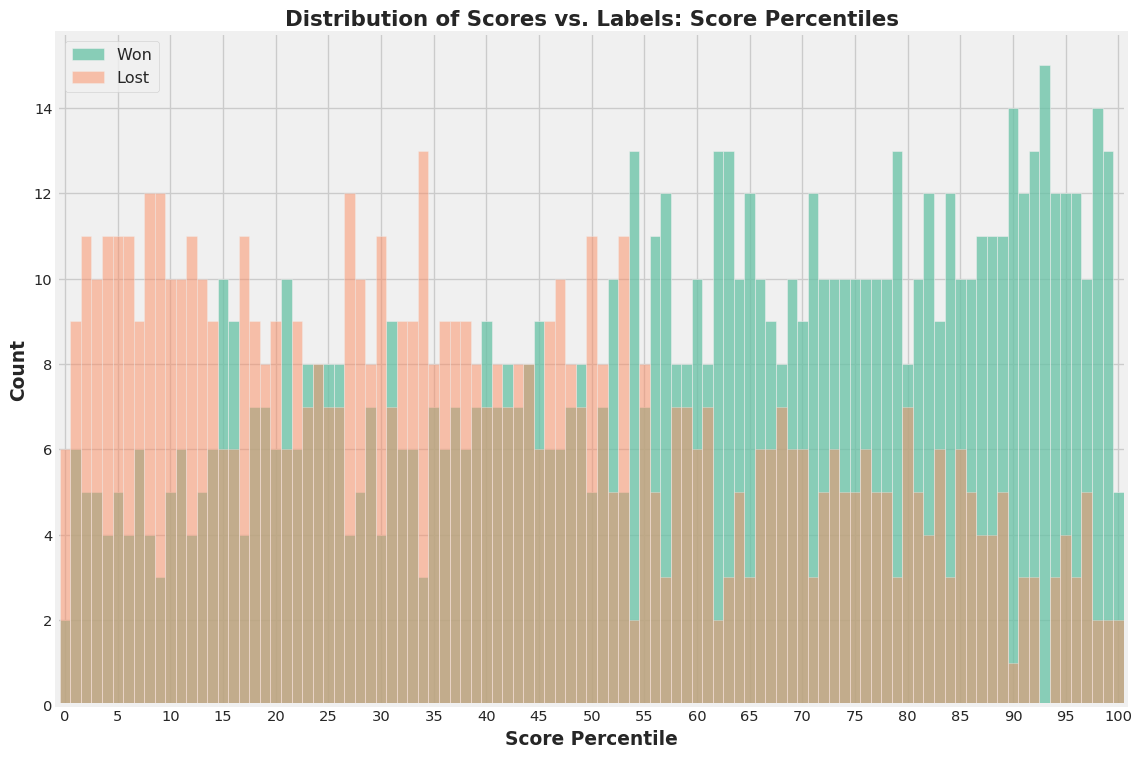

<Figure size 1152x768 with 0 Axes>

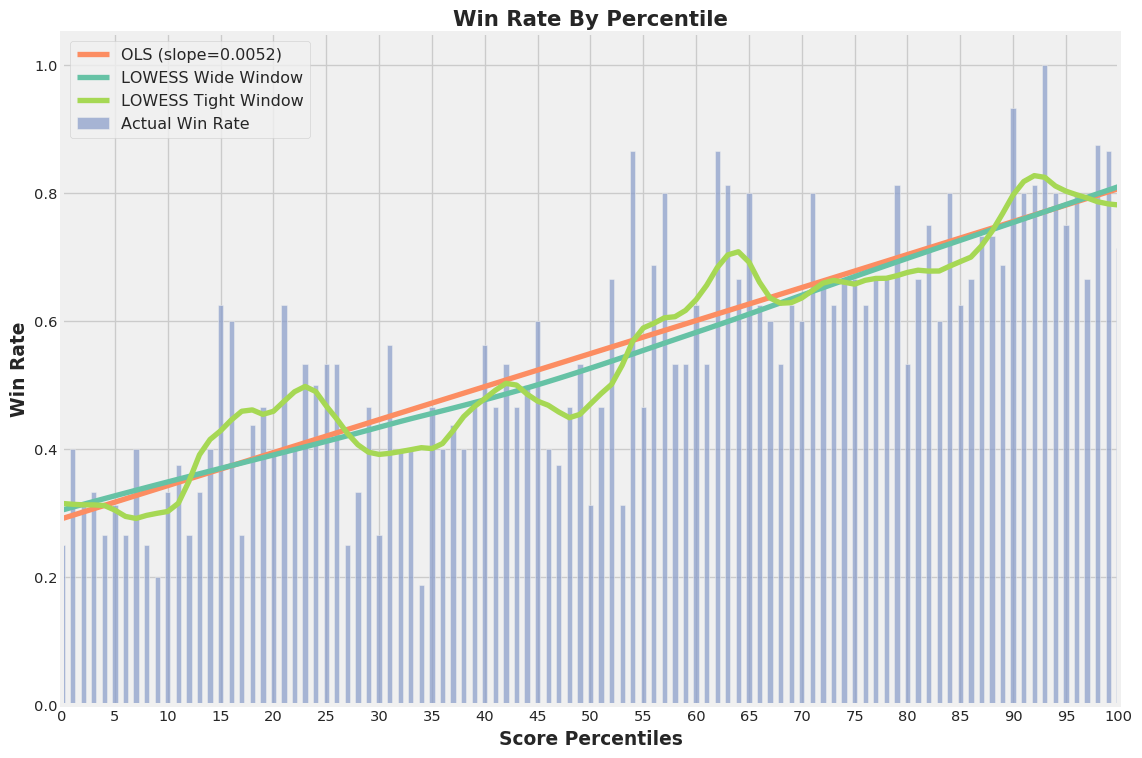

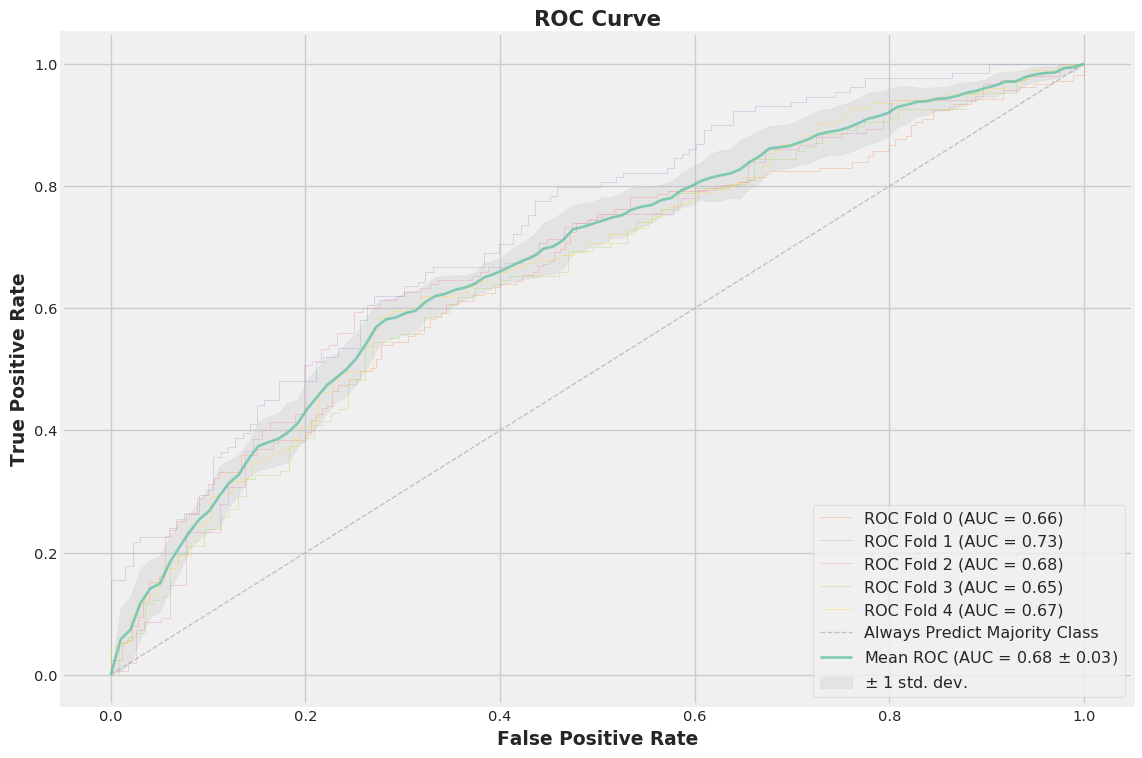

<Figure size 1152x768 with 0 Axes>

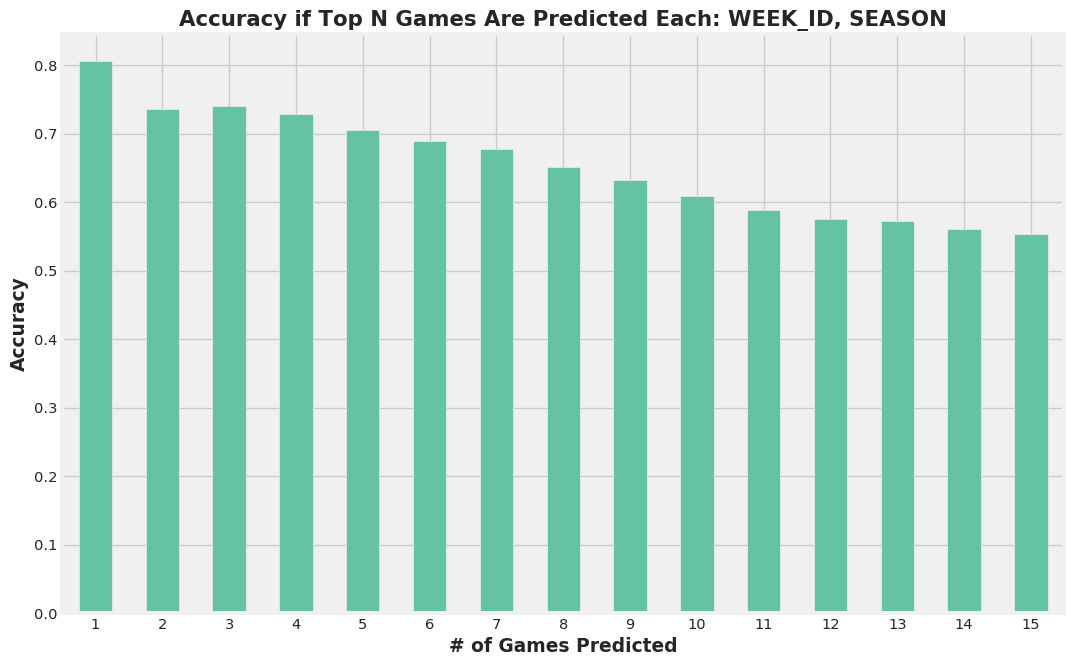

<Figure size 1152x768 with 0 Axes>

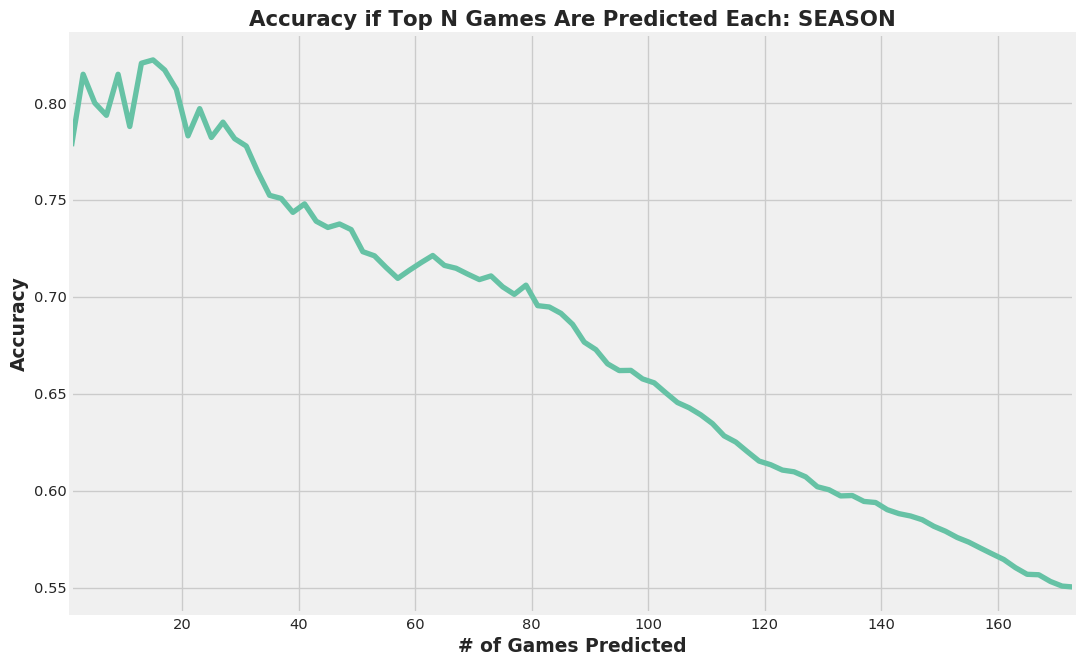

<Figure size 1152x768 with 0 Axes>

In [33]:
plots_dict['save_plots'] = False
plot = EvaluateAndPlot(plots_dict, scores_df)

plot.ridge_viz(ridge_df)
mpl.rcParams.update(params_backup)

for metric in plot.plots_dict['threshold_metrics']:
    plot.plot_by_threshold(acc_dfs[metric], metric)

for bin_type in plot.plots_dict['bin_types']:
    for nbins in plot.plots_dict['plot_bins']:
        inputs = (bins_dfs[bin_type][nbins], bin_type, nbins)
        plot.bin_viz(*inputs)
        if bin_type == 'Percentile':
            plot.bin_trend_viz(*inputs)
            
plot.plot_roc_kfold_errband(plot.get_roc_sets())
for col_range in plot.plots_dict['accuracy_at_topn'].keys():
    plot.accuracy_by_topn_viz(acc_topn[col_range], col_range)

### "Where do we miss?" in Evaluation??
* week id
* season
* team?
* by spread, ML
* by O/U

### Timer

### Move feature importance out of train_score

In [ ]:
###